In [3]:
import torch
from torch import nn, tensor
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import torchvision.transforms.functional as TF
from functools import partial
from torcheval.metrics import MulticlassAccuracy
from torch import optim
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt

from minai.datasets import inplace
from minai.learner import DataLoaders, MetricsCB, DeviceCB, ProgressCB, TrainLearner, MomentumLearner, LRFinderCB, SingleBatchCB, Callback
from minai.init import get_model, GeneralRelu,init_weights
from minai.activations import ActivationStats, set_seed

set_seed(42)

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


# Data

In [4]:
bs=1024
x1, y1 = 'image', 'label'
ds = load_dataset('fashion_mnist')

In [5]:
ds['train'][x1][0]

In [6]:
x_mean, x_std = tensor(0.28), tensor(0.35)

@inplace
def transformi(b): b[x1] = [(TF.to_tensor(o) - x_mean)/x_std for o in b[x1]]

In [7]:
dsd = ds.with_transform(transformi)

In [8]:
dls = DataLoaders.from_dd(dsd, batch_size=bs)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [9]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.01))

# SGD

In [10]:
class SGD:
    def __init__(self, params, lr, wd=1e-6):
        params = list(params)
        fc.store_attr()
        self.i = 0
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self, p): p -= p.grad * self.lr
    
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr * self.wd 
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_() #p.zero_grad()

In [11]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights,leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())

lrf_cbs = [DeviceCB(), ProgressCB(plot=True), LRFinderCB()]
cbs = [DeviceCB(), ProgressCB(plot=True), metrics]

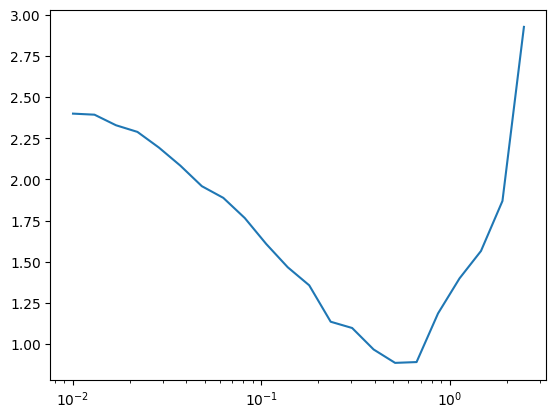

In [12]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-2, cbs=lrf_cbs)
learn.fit(1)

accuracy,loss,epoch,train
0.705,0.898,0,True
0.784,0.614,0,False
0.808,0.540,1,True
0.812,0.519,1,False
0.831,0.471,2,True
0.827,0.476,2,False


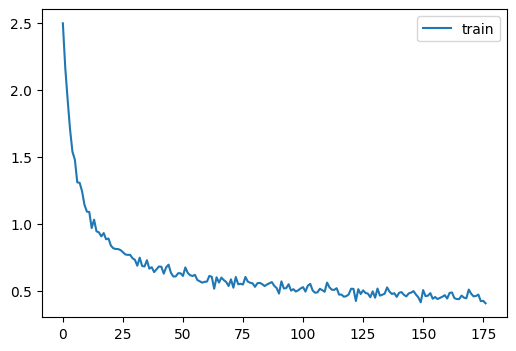

In [13]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs, opt_func=SGD)
learn.fit(3)

## Momentum

In [14]:
class Momentum(SGD):
    def __init__(self, params, lr, wd = 0., mom=0.9):
        super().__init__(params, lr, wd)
        self.mom = mom
    
    def opt_step(self, p):
        if self.i==0: p.avg_grad = torch.zeros_like(p.grad)
        p.avg_grad = self.mom * p.avg_grad + (1 - self.mom) * p.grad
        p -= self.lr * p.avg_grad

accuracy,loss,epoch,train
0.638,1.063,0,True
0.763,0.665,0,False
0.794,0.583,1,True
0.798,0.563,1,False
0.819,0.510,2,True
0.816,0.514,2,False


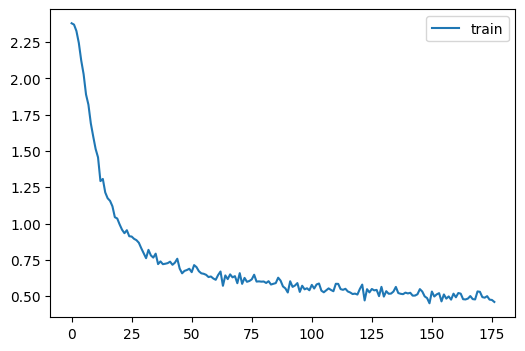

In [15]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs, opt_func=Momentum)
learn.fit(3)

## RMSProp

In [16]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-6):
        super().__init__(params, lr, wd)
        self.sqr_mom = sqr_mom
        self.eps = eps
    
    def opt_step(self, p):
        if self.i == 0: p.grad_sqr = p.grad ** 2
        p.grad_sqr = self.sqr_mom * p.grad_sqr + (1 - self.sqr_mom) * (p.grad ** 2)
        upd = p.grad / (p.grad_sqr.sqrt() + self.eps)
        p -= self.lr * upd

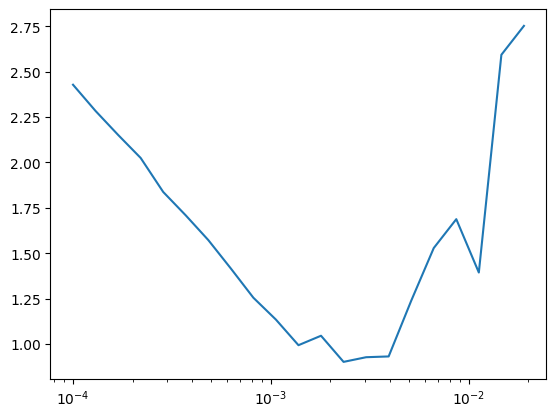

In [17]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs, opt_func=optim.RMSprop)
learn.fit(1)

accuracy,loss,epoch,train
0.774,0.632,0,True
0.843,0.437,0,False
0.855,0.392,1,True
0.858,0.389,1,False
0.871,0.350,2,True
0.861,0.385,2,False


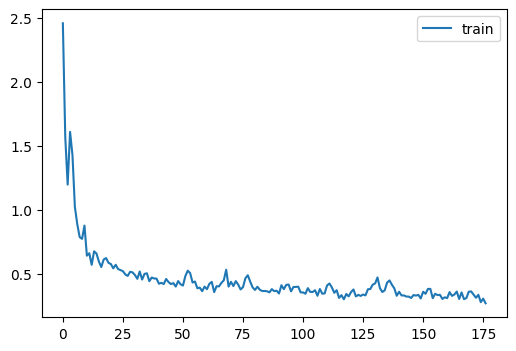

In [18]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

## Adam
> RMSProp + Momentum

In [19]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-6):
        super().__init__(params, lr, wd)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
    
    def opt_step(self, p):
        if self.i == 0: 
            p.sqr_grad = torch.zeros_like(p.grad)
            p.avg_grad = torch.zeros_like(p.grad)
        
        p.sqr_grad = p.sqr_grad * self.beta2 + (1 - self.beta2) * p.grad** 2
        unbiased_sqr_grad = p.sqr_grad / (1 - self.beta2**(self.i + 1))
        
        p.avg_grad = p.avg_grad * self.beta1 + (1 - self.beta1) * p.grad
        unbiased_avg_grad = p.avg_grad / (1 - self.beta1**(self.i + 1))
        
        p -= self.lr * (unbiased_avg_grad/(unbiased_sqr_grad + self.eps).sqrt())

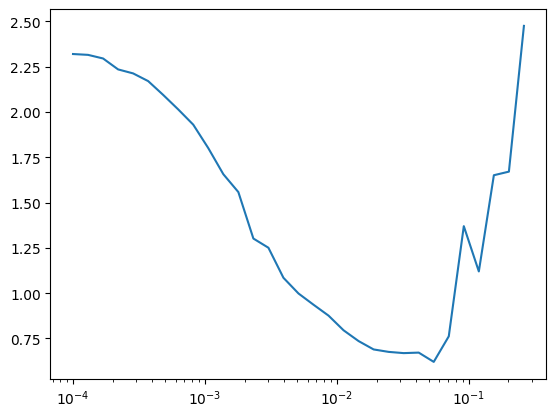

In [20]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs, opt_func=optim.Adam)
learn.fit(1)

accuracy,loss,epoch,train
0.659,1.032,0,True
0.785,0.611,0,False
0.820,0.509,1,True
0.825,0.482,1,False
0.850,0.420,2,True
0.842,0.430,2,False


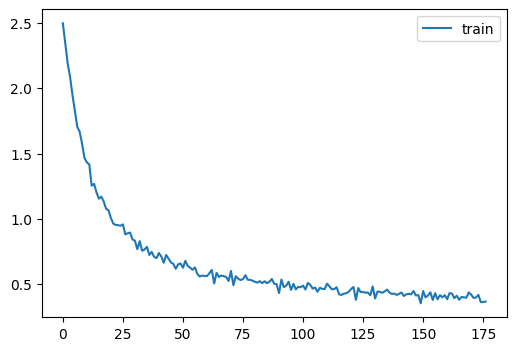

In [21]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

accuracy,loss,epoch,train
0.864,0.376,0,True
0.857,0.398,0,False
0.877,0.341,1,True
0.864,0.377,1,False
0.886,0.319,2,True
0.869,0.363,2,False
0.892,0.301,3,True
0.870,0.352,3,False
0.897,0.287,4,True
0.874,0.343,4,False


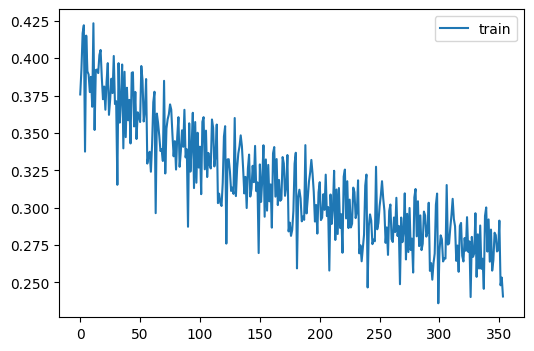

In [ ]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=cbs, opt_func=Adam)
learn.fit(6)

## Scheduler

In [ ]:
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [ ]:
[o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower()]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR']

In [ ]:
from fastcore.basics import Self as X

In [ ]:
list(filter(X[0].isupper() and X[1].islower(), dir(lr_scheduler)))

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()], lr=6e-3, opt_func=optim.AdamW)
learn.fit(1)

In [ ]:
params = next(iter(learn.model.parameters()))

In [ ]:
opt = learn.opt; opt

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.006
    maximize: False
    weight_decay: 0.01
)

In [ ]:
opt.state[params]

{'step': tensor(1.),
 'exp_avg': tensor([[[[     0.00,      0.00,      0.00],
           [     0.00,     -0.00,     -0.00],
           [    -0.00,     -0.00,     -0.00]]],
 
 
         [[[    -0.00,      0.00,     -0.00],
           [    -0.00,      0.00,     -0.00],
           [    -0.00,      0.00,     -0.00]]],
 
 
         [[[     0.00,      0.00,     -0.00],
           [     0.00,      0.00,      0.00],
           [     0.00,      0.00,      0.00]]],
 
 
         [[[    -0.00,     -0.00,     -0.00],
           [    -0.00,      0.00,      0.00],
           [    -0.00,      0.00,      0.00]]],
 
 
         [[[    -0.00,     -0.00,      0.00],
           [    -0.00,     -0.00,      0.00],
           [    -0.00,      0.00,      0.00]]],
 
 
         [[[     0.00,      0.00,      0.00],
           [     0.01,      0.00,      0.00],
           [     0.01,      0.00,      0.00]]],
 
 
         [[[     0.01,      0.01,      0.01],
           [     0.01,      0.01,      0.01],
           [

In [ ]:
list(opt.param_groups[0])

['params',
 'lr',
 'betas',
 'eps',
 'weight_decay',
 'amsgrad',
 'foreach',
 'maximize',
 'capturable']

In [ ]:
sched = lr_scheduler.CosineAnnealingLR(opt, T_max=len(dls.train))
sched.get_last_lr(), sched.base_lrs

([0.006], [0.006])

In [ ]:
def plot_lr():
    steps = len(dls.train) * 3
    sched = lr_scheduler.CosineAnnealingLR(opt, T_max=steps)
    lrs = [sched.base_lrs[0]]
    for i in range(steps):
        sched.step()
        lrs.append(sched.get_last_lr()[0])
    plt.plot(lrs, label='lr')
    plt.legend()
    plt.show()

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


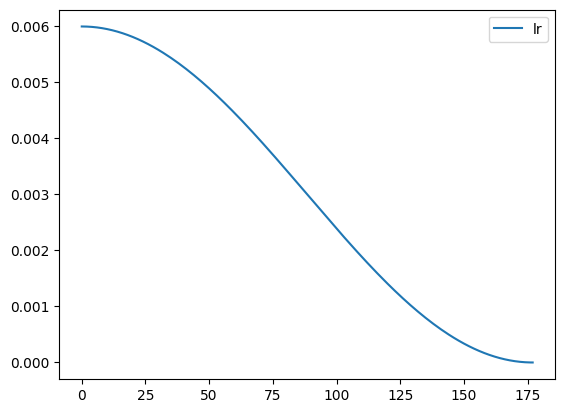

In [ ]:
plot_lr()

In [ ]:
class BaseSchedCB(Callback):
    def __init__(self, sched): fc.store_attr()
    def before_fit(self, learn): 
        self.schedo = self.sched(learn.opt)
    def step(self, learn):
        if learn.training: self.schedo.step()

In [ ]:
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn):
        self.step(learn)

In [ ]:
class RecorderCB(Callback):
    def __init__(self, **d):
        self.d = d
        
    def before_fit(self, learn):
        self.recs = {k: [] for k in self.d}
        self.pg = learn.opt.param_groups[0]
        
    def after_batch(self, learn):
        if learn.training:
            for k, v in self.d.items():
                self.recs[k].append(v(self))
    
    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [ ]:
def _lr(cb): return cb.pg['lr']

accuracy,loss,epoch,train
0.789,0.592,0,True
0.846,0.423,0,False
0.869,0.358,1,True
0.864,0.371,1,False
0.885,0.319,2,True
0.868,0.362,2,False


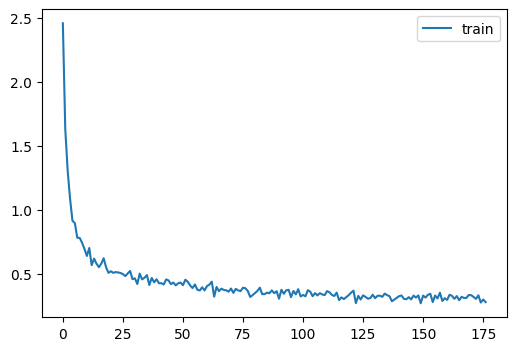

In [ ]:
epochs = 3
steps = len(dls.train) * epochs
rec = RecorderCB(lr=_lr)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra_cbs = [BatchSchedCB(partial(lr_scheduler.CosineAnnealingLR, T_max=steps)), rec]
learn = TrainLearner(model, dls, F.cross_entropy, cbs=cbs + xtra_cbs, lr=6e-3, opt_func=optim.AdamW)
learn.fit(epochs)

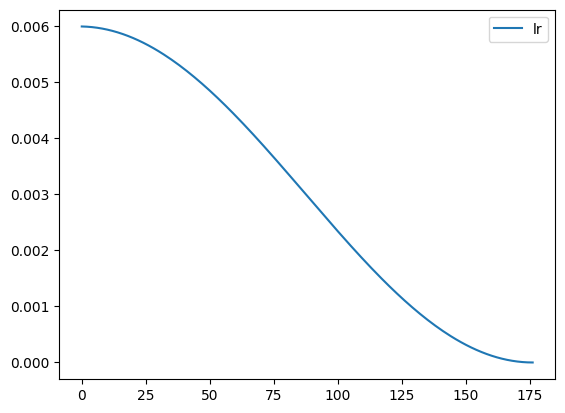

In [ ]:
rec.plot()

In [ ]:
def _beta(cb): return cb.pg['betas'][0]

accuracy,loss,epoch,train
0.799,0.558,0,True
0.851,0.408,0,False
0.873,0.345,1,True
0.865,0.367,1,False
0.888,0.308,2,True
0.869,0.358,2,False


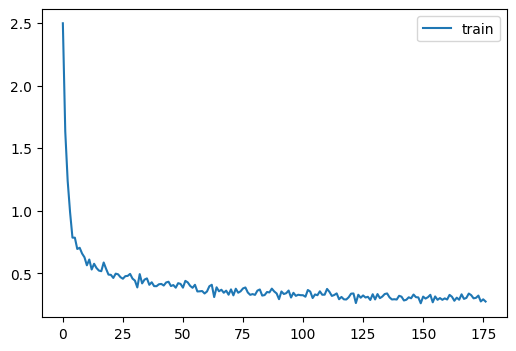

In [ ]:
set_seed(42)
epochs = 3
steps = len(dls.train) * epochs
rec = RecorderCB(lr=_lr, beta=_beta)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra_cbs = [BatchSchedCB(partial(lr_scheduler.CosineAnnealingLR, T_max=steps)), rec]
learn = TrainLearner(model, dls, F.cross_entropy, cbs=cbs + xtra_cbs, lr=6e-3, opt_func=optim.AdamW)
learn.fit(epochs)

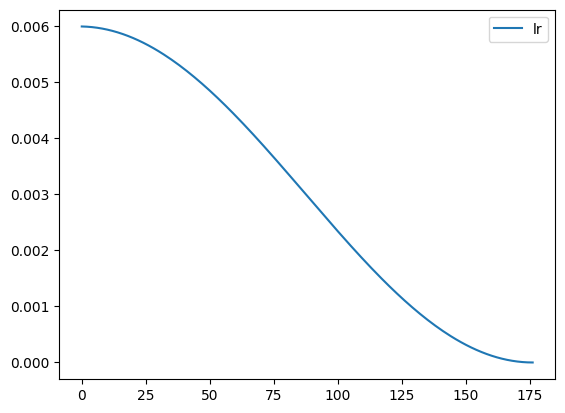

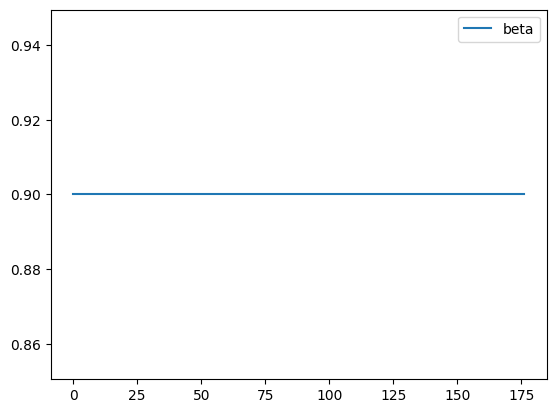

In [ ]:
rec.plot()

accuracy,loss,epoch,train
0.769,0.653,0,True
0.833,0.491,0,False
0.857,0.393,1,True
0.859,0.395,1,False
0.886,0.308,2,True
0.877,0.357,2,False
0.907,0.254,3,True
0.897,0.284,3,False
0.922,0.212,4,True
0.902,0.269,4,False


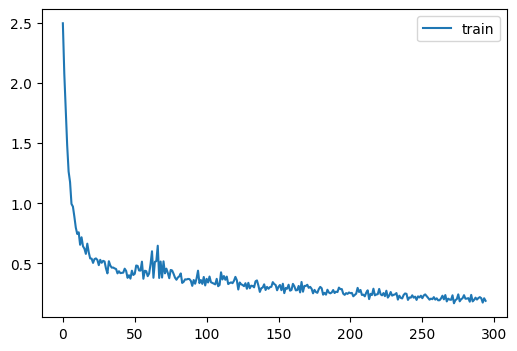

In [ ]:
set_seed(42)
epochs = 5
lr = 6e-2
steps = len(dls.train) * epochs
rec = RecorderCB(lr=_lr, beta=_beta)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra_cbs = [BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps=steps)), rec]
learn = TrainLearner(model, dls, F.cross_entropy, cbs=cbs + xtra_cbs, lr=lr, opt_func=optim.AdamW)
learn.fit(epochs)

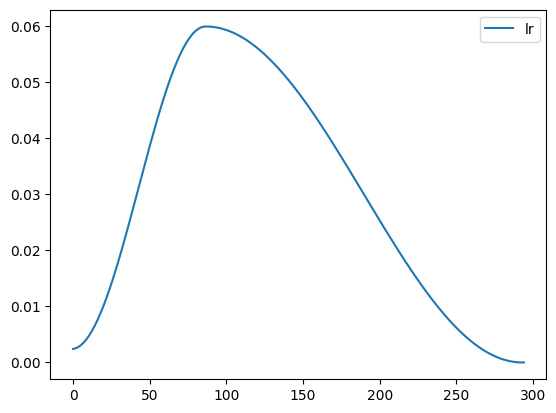

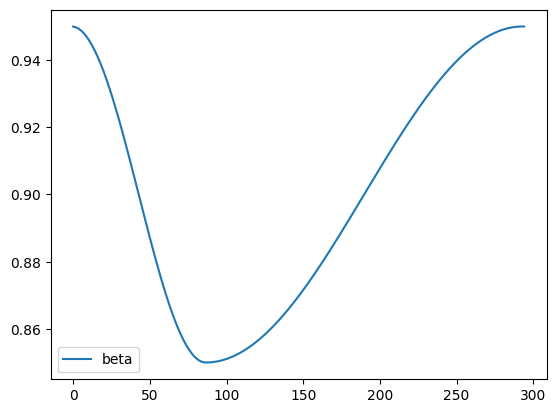

In [ ]:
rec.plot()

In [46]:
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn):
        self.step(learn)

accuracy,loss,epoch,train
0.801,0.562,0,True
0.848,0.415,0,False
0.876,0.338,1,True
0.867,0.362,1,False
0.888,0.308,2,True
0.866,0.362,2,False


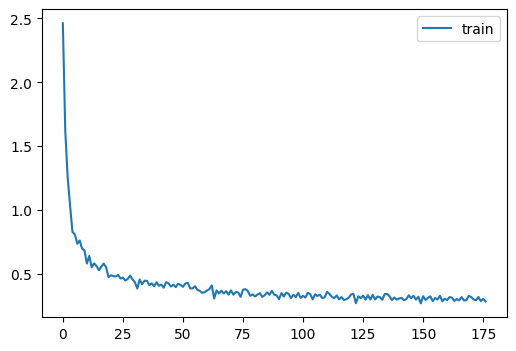

In [47]:
epochs = 3
lr = 6e-3
steps = len(dls.train) * epochs
rec = RecorderCB(lr=_lr, beta=_beta)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra_cbs = [EpochSchedCB(partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps=epochs)), rec]
learn = TrainLearner(model, dls, F.cross_entropy, cbs=cbs + xtra_cbs, lr=lr, opt_func=optim.AdamW)
learn.fit(epochs)

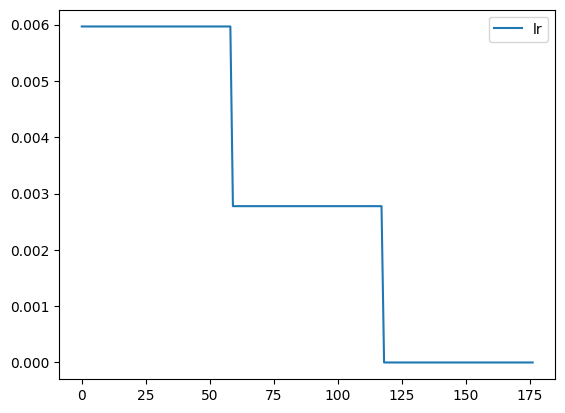

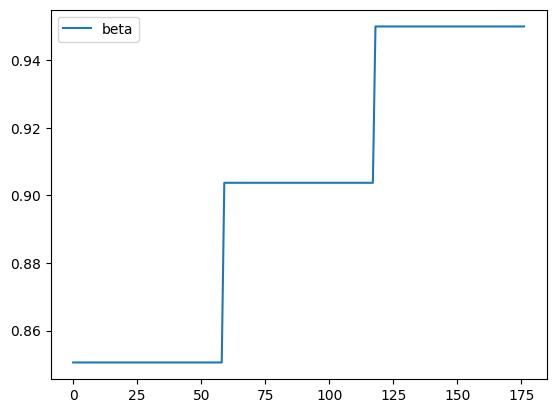

In [48]:
rec.plot()